## Mini Project III

1. Read in data into df - choose columns to use (and get to know data)
2. Data prep & engineering: covert to numeric, check for nulls, covert /combine columns, check columns data make sense etc and record
3. Clustering (3-5)   ( centroid, density, hierarchical, - anova? feature reduction, pca...,)
* demographics
* baking behaviour (savings account balance, credit debit, transaction size vs amounts)
4. PCS to reduce observations to 2D

5. (stretch what happens to clusters over 20 iterations of kmeans)

### Presentation Output
  - data using, assumptions and inputs to clustering - any changes done to data (eg correlation plots to indicate why some eliminated)
  - output clustering and RADAR chart
  - PCA 2d chart 
  - which techniques used 
  - story...



In [64]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

# kmeans
from sklearn.cluster import KMeans

# cluster hierarchy
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# import DBSCAN
from sklearn.cluster import DBSCAN

# visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


In [76]:
accounts = pd.read_csv("data/twm_accounts.csv", sep=';')
checking_acct = pd.read_csv("data/twm_checking_acct.csv", sep=';')
checking_tran = pd.read_csv("data/twm_checking_tran.csv", sep=';')
credit_acct = pd.read_csv("data/twm_credit_acct.csv", sep=';')
customer = pd.read_csv("data/twm_customer.csv", sep=';')
savings_acct = pd.read_csv("data/twm_savings_acct.csv", sep=';')
savings_tran = pd.read_csv("data/twm_savings_tran.csv", sep=';')
transactions = pd.read_csv("data/twm_transactions.csv", sep=';')

### 1. Demographics - Data Exploration

In [15]:
# accounts.head()

In [77]:
customer.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [5]:
customer.shape

(747, 15)

In [6]:
customer.dtypes

cust_id             int64
income              int64
age                 int64
years_with_bank     int64
nbr_children        int64
gender             object
marital_status      int64
name_prefix        object
first_name         object
last_name          object
street_nbr          int64
street_name        object
postal_code         int64
city_name          object
state_code         object
dtype: object

In [7]:
customer.city_name.nunique()

69

In [8]:
customer.postal_code.nunique()

442

In [9]:
customer.state_code.nunique()

33

In [78]:
idsUnique = len(set(customer.cust_id))
idsTotal = customer.shape[0]
isdupe = idsTotal - idsUnique
print(isdupe)

# no duplicate entries

0


In [79]:
customer.isnull().sum().sort_values(ascending=False)

# no null values

state_code         0
city_name          0
postal_code        0
street_name        0
street_nbr         0
last_name          0
first_name         0
name_prefix        0
marital_status     0
gender             0
nbr_children       0
years_with_bank    0
age                0
income             0
cust_id            0
dtype: int64

In [80]:
customer.describe()

,cust_id,income,age,years_with_bank,nbr_children,marital_status,street_nbr,postal_code
count,7.470000e+02,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,1.362991e+06,22728.281124,42.479250,3.907631,0.714859,1.882195,8523.109772,59502.690763
std,2.925255e+02,22207.221405,19.114879,2.675634,1.103410,0.892051,5219.488263,31205.926508
min,1.362480e+06,0.000000,13.000000,0.000000,0.000000,1.000000,196.000000,2149.000000
25%,1.362732e+06,7118.500000,28.000000,2.000000,0.000000,1.000000,4295.500000,33145.000000
50%,1.362993e+06,17242.000000,42.000000,4.000000,0.000000,2.000000,8001.000000,64132.000000
75%,1.363244e+06,31338.000000,56.000000,6.000000,1.000000,2.000000,12039.000000,90082.000000
max,1.363495e+06,144157.000000,89.000000,9.000000,5.000000,4.000000,19940.000000,98186.000000


### 2. Value Transformation 

* check if skewed??
* find outliers ??
* Marital status, city_name and state_code to dummy
* Scale everything

In [111]:
# city name?  What else would be included here? postal_code - too many unique, should we combine city/ state? (double cities than states)
# demographics_df = customer[['income', 'age', 'gender', 'nbr_children', 'marital_status', 'city_name', 'state_code']]
demographics_df = customer[['income', 'age', 'gender', 'nbr_children', 'marital_status']]

In [112]:
demographics_df

,income,age,gender,nbr_children,marital_status
0,26150,46,M,1,2
1,6605,71,M,0,2
2,18548,38,F,0,1
3,47668,54,F,0,1
4,44554,59,F,2,4
...,...,...,...,...,...
742,14795,36,F,1,4
743,26387,56,M,1,2
744,61300,50,M,2,2
745,15100,37,F,0,2


## *NEED TO NORMALIZE THE FOLLOWING! 
Try log - if not...
BOX-COX TRANSFORMATION or quantile?
https://scikit-learn.org/stable/modules/preprocessing.html

In [113]:
# check if skewed
# num_feats = demographics_df.dtypes[demographics_df.dtypes != 'object'].index.tolist()
# num_feats = ['income', 'age', 'nbr_children']

Income mean: 22728.281124497993, median: 17242.0


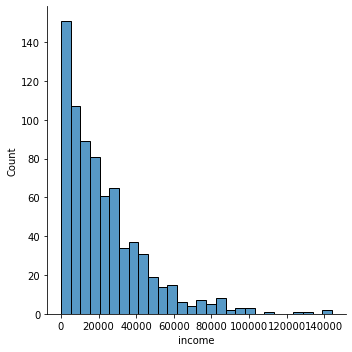

In [114]:
sns.displot(demographics_df["income"]);
print(f'Income mean: {demographics_df["income"].mean()}, median: {demographics_df["income"].median()}')

/var/folders/q4/f3xj1m3j2h3fl1lc7921wysh0000gn/T/ipykernel_52251/2421348708.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



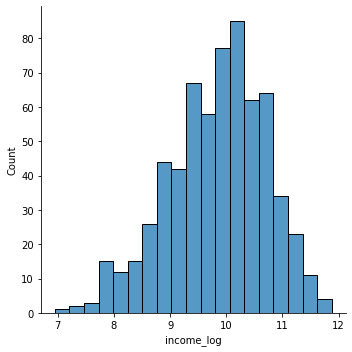

In [174]:
demographics_df["income_log"] = demographics_df["income"].apply(np.log)
sns.displot(demographics_df["income_log"]);

age:  mean: 42.479250334672024, median: 42.0


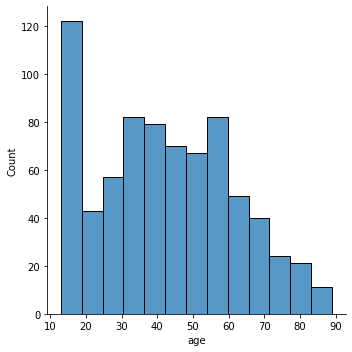

In [19]:
sns.displot(demographics_df["age"]);
print(f'age:  mean: {demographics_df["age"].mean()}, median: {demographics_df["age"].median()}')

age:  mean: 42.479250334672024, median: 42.0


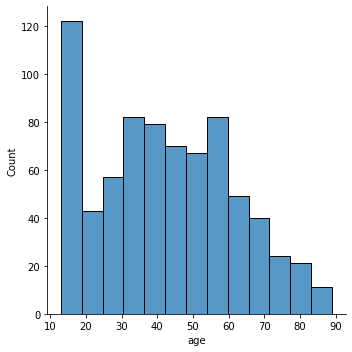

In [116]:
sns.displot(demographics_df["age"]);
print(f'age:  mean: {demographics_df["age"].mean()}, median: {demographics_df["age"].median()}')

Number Children:  mean: 0.714859437751004, median: 0.0


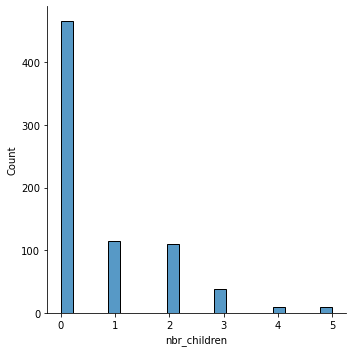

In [20]:
sns.displot(demographics_df["nbr_children"]);
print(f'Number Children:  mean: {demographics_df["nbr_children"].mean()}, median: {demographics_df["nbr_children"].median()}')

/var/folders/q4/f3xj1m3j2h3fl1lc7921wysh0000gn/T/ipykernel_52251/2190709281.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



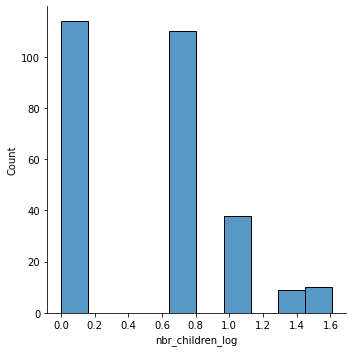

In [117]:
demographics_df["nbr_children_log"] = demographics_df["nbr_children"].apply(np.log)
sns.displot(demographics_df["nbr_children_log"]);

In [ ]:

# Note mean / median has no meaning for marital status - just coded
# sns.displot(demographics_df["marital_status"]);
# print(f'marital_status:  mean: {demographics_df["marital_status"].mean()}, median: {demographics_df["marital_status"].median()}')

### Scale

In [175]:
from sklearn.preprocessing import MinMaxScaler
num_feats = ['income_log', 'age', 'nbr_children']
# num_feats = list('income_log', 'age_log', 'nbr_children'

scaler = MinMaxScaler()
demographics_scaled = pd.DataFrame(scaler.fit_transform(demographics_df[num_feats].astype(float)))
# demographics_scaled.columns = num_feats
# demographics_scaled.head()

ValueError: Input contains infinity or a value too large for dtype('float64').

In [119]:
# # will need to log other columns first before this 

# scaler = StandardScaler()
# demographics_scaled = pd.DataFrame(scaler.fit_transform(demographics_df[num_feats].astype(float)))
# demographics_scaled.columns = num_feats
# demographics_scaled.head()

,income,age,nbr_children
0,0.154185,0.184312,0.258591
1,-0.726524,1.493070,-0.648298
2,-0.188366,-0.234490,-0.648298
3,1.123798,0.603115,-0.648298
4,0.983479,0.864867,1.165479


### dummy variables

In [121]:
demographics_df['marital_status'].unique()

array([2, 1, 4, 3])

In [122]:
# for some reason 'marital status' won't dummy code - convert to alpha
demographics_df['marital_status'] = demographics_df.marital_status.replace({1 : 'A',
                                                     2 : 'B', 
                                                     3 : 'C', 4 : 'D' 
                                                    })

/var/folders/q4/f3xj1m3j2h3fl1lc7921wysh0000gn/T/ipykernel_52251/381180482.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [123]:
demographics_df['marital_status'].unique()

array(['B', 'A', 'D', 'C'], dtype=object)

In [137]:
# add marital status
cat_feats = demographics_df.dtypes[demographics_df.dtypes == 'object'].index.tolist()
# cat_feats = cat_feats +['marital_status']
# cat_feats = ['gender', 'state_code']
cat_feats = ['gender', 'marital_status']

In [179]:
demo_dummy = pd.get_dummies(demographics_df[cat_feats])
demo_dummy.drop(['marital_status_C', 'marital_status_D'], inplace = True, axis=1)


In [180]:
demo_dummy.head()

,gender_F,gender_M,marital_status_A,marital_status_B
0,0,1,0,1
1,0,1,0,1
2,1,0,1,0
3,1,0,1,0
4,1,0,0,0


### TRY THIS AGAIN BUT WITHOUT CITY OR STATE (TOO MANY VARIABLES FOR NUMBER OF DATA POINTS) *

### Combine back into one dataframe

In [181]:
print(demographics_scaled.shape, demo_dummy.shape)

(747, 3) (747, 4)


In [182]:
demographics_all_numeric = pd.concat([demographics_scaled, demo_dummy], axis=1)

In [183]:
demographics_all_numeric.shape

(747, 7)

### Remove Small Variance and correlation

In [184]:
# Variance
def remove_small_variance(x, variance_threshold = 0.1):
    vt = VarianceThreshold(variance_threshold)
    x_transformed = vt.fit_transform(x)
    selected_columns = x.columns[vt.get_support()]
    x_transformed = pd.DataFrame(x_transformed, columns = selected_columns)
    return(x_transformed)

# Correlation
def remove_correlated_features(df, correlation_threshold=0.92):
#     Anything above correlation threshold will be tossed
# Assumptions - all numeric, target variable removed
    # step 1
    df_corr = df.corr().abs()

    # step 2
    indices = np.where(df_corr > correlation_threshold) 
    indices = [(df_corr.index[x], df_corr.columns[y]) 
    for x, y in zip(*indices)
        if x != y and x < y]

    # step 3
    for idx in indices: #each pair
        try:
            df.drop(idx[1], axis = 1, inplace=True)
        except KeyError:
            pass
    return(df)

In [99]:
# # use fucntions if want to remove variance/ correlation

# # THIS WILL ELIMINATE DUMMY VARIABLES
# resize_demo = remove_small_variance(demographics_all_numeric)
# resize_demo.shape

# # PERHAPS DO THIS BEFORE DUMMY VARIABLES? - DECIDE IF TO KEEP CITY AND STATE

(747, 4)

In [185]:
# KEEP THIS ONE
resize_demo = remove_correlated_features(demographics_all_numeric)
resize_demo.shape
resize_demo.head()

,income,age,nbr_children,gender_F,marital_status_A,marital_status_B
0,0.181399,0.434211,0.2,0,0,1
1,0.045818,0.763158,0.0,0,0,1
2,0.128665,0.328947,0.0,1,1,0
3,0.330667,0.539474,0.0,1,1,0
4,0.309066,0.605263,0.4,1,0,0


## Clustering
### k- means

Elbow plot to discover number of clusters to choose - 4-5?

In [230]:
resize_demo

,income,age,nbr_children,gender_F,marital_status_A,marital_status_B,y_km,y_db
0,0.181399,0.434211,0.2,0,0,1,2,0
1,0.045818,0.763158,0.0,0,0,1,2,0
2,0.128665,0.328947,0.0,1,1,0,3,1
3,0.330667,0.539474,0.0,1,1,0,3,1
4,0.309066,0.605263,0.4,1,0,0,5,2
...,...,...,...,...,...,...,...,...
742,0.102631,0.302632,0.2,1,0,0,5,2
743,0.183043,0.565789,0.2,0,0,1,2,0
744,0.425231,0.486842,0.4,0,0,1,2,0
745,0.104747,0.315789,0.0,1,0,1,1,3


In [201]:
demo_clustered = resize_demo
demo_dummy.drop(['marital_status_C', 'marital_status_D'], inplace = True, axis=1)


In [360]:
demo_clustered.drop(['y_db'], inplace = True, axis=1)

In [361]:
X= demo_clustered

def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

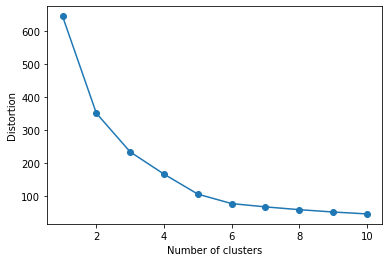

In [362]:
plot_distortion(X,max_clusters=10)

In [206]:
# Perform kmeans


km = KMeans(n_clusters=6, # how many clusters we expected 
            n_init=10, # how many initial runs
            random_state=0) # set the random_state parameter to easily reproduce the results.
y_km = km.fit_predict(X)

In [207]:
km6_demographics = X
km6_demographics['y_km'] = y_km

km6_demographics.head()

,income,age,nbr_children,gender_F,marital_status_A,marital_status_B,y_km
0,0.181399,0.434211,0.2,0,0,1,2
1,0.045818,0.763158,0.0,0,0,1,2
2,0.128665,0.328947,0.0,1,1,0,3
3,0.330667,0.539474,0.0,1,1,0,3
4,0.309066,0.605263,0.4,1,0,0,5


In [190]:
y_km.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# plot various cat against y_km

### Agglomerative clustering

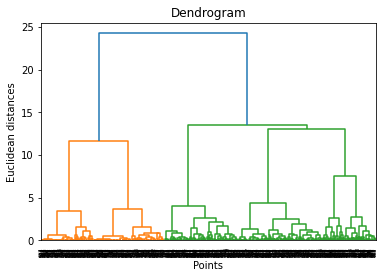

In [346]:
# plot dendrogram
X = resize_demo
def plot_dendrogram(X,method ='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()
    
plot_dendrogram(X)

In [349]:
# The next step is to create an object from the AgglomerativeClustering class
ac = AgglomerativeClustering(affinity='euclidean',
                             linkage='ward', #The linkage criteria determine the metric used for the merge strategy
                             n_clusters = 6)
y_hc = ac.fit_predict(X)

In [350]:
hc_demographics = demographics_df
hc_demographics['y_hc'] = y_hc
hc_demographics.head()

/var/folders/q4/f3xj1m3j2h3fl1lc7921wysh0000gn/T/ipykernel_52251/3199990046.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,income,age,gender,nbr_children,marital_status,income_log,y_km,y_hc,y_db
0,26150,46,M,1,B,10.171604,2,2,1
1,6605,71,M,0,B,8.795582,2,2,1
2,18548,38,F,0,A,9.828117,3,1,3
3,47668,54,F,0,A,10.772016,3,1,3
4,44554,59,F,2,D,10.704457,5,3,4


In [ ]:
# plot to see if makes sense (agains yhc) (correlation plot)

### DBSCAN

In [351]:
# create an instance of DBSCAN class from the Sklearn library
# mess with variables eps and min_samples! 
X = resize_demo
db = DBSCAN(eps=1.0,
            min_samples=5,
            metric='euclidean')
# fit and predict
y_db = db.fit_predict(X)

In [352]:
# db_demographics = X
# db_demographics['y_db'] = y_db
# db_demographics.head()

,income,age,nbr_children,gender_F,marital_status_A,marital_status_B,y_db
0,0.181399,0.434211,0.2,0,0,1,0
1,0.045818,0.763158,0.0,0,0,1,0
2,0.128665,0.328947,0.0,1,1,0,1
3,0.330667,0.539474,0.0,1,1,0,1
4,0.309066,0.605263,0.4,1,0,0,2


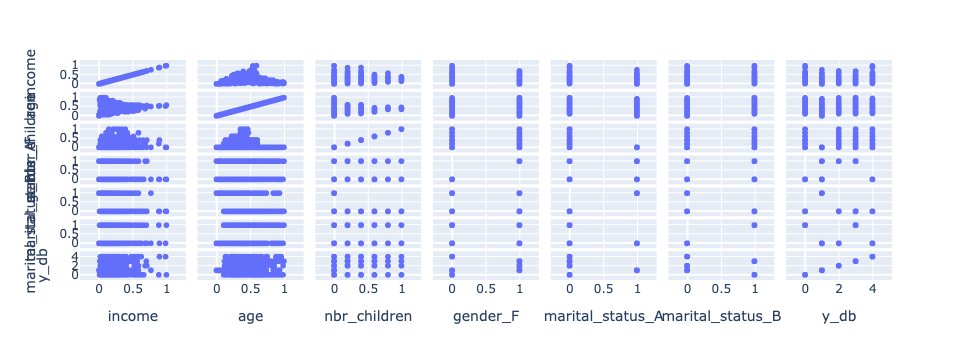

In [353]:
fig = px.scatter_matrix(X)
fig.show()
# too many outliers! 
# adjust

### USE PCA TO FIGURE OUT WHERE THE IMPACT IS COMING FROM AND PLOT IN 2D

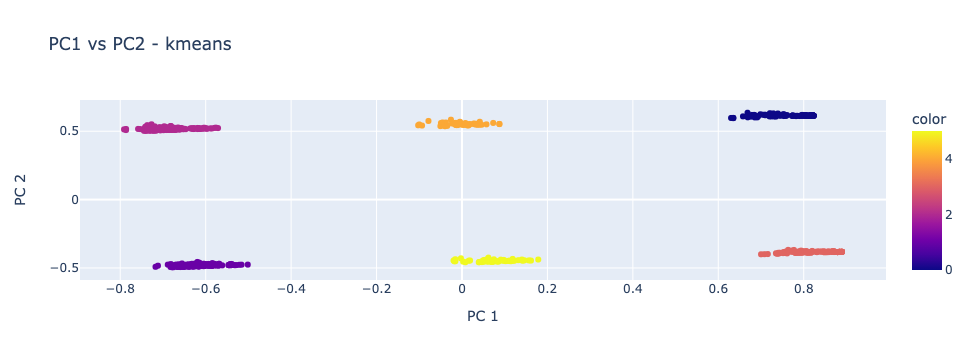

In [363]:
# X = resize_demo
X = resize_demo

pca = PCA(n_components=2)
components = pca.fit_transform(X)



# km_5
fig = px.scatter(
    components, x=0, y=1, color=y_km,
#     title=f'Total Explained Variance: {total_var:.2f}%',
    title=f'PC1 vs PC2 - kmeans',
    labels={'0': 'PC 1', '1': 'PC 2'}
)

fig.show()
                               

In [364]:
X.head()

,income,age,nbr_children,gender_F,marital_status_A,marital_status_B
0,0.181399,0.434211,0.2,0,0,1
1,0.045818,0.763158,0.0,0,0,1
2,0.128665,0.328947,0.0,1,1,0
3,0.330667,0.539474,0.0,1,1,0
4,0.309066,0.605263,0.4,1,0,0


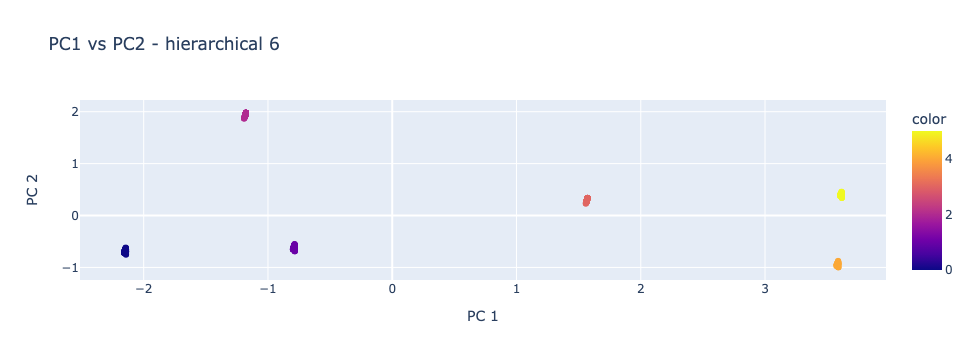

In [223]:
# hierarchical
fig = px.scatter(
    components, x=0, y=1, color=hc_demographics['y_hc'],
#     title=f'Total Explained Variance: {total_var:.2f}%',
    title=f'PC1 vs PC2 - hierarchical 6',
    labels={'0': 'PC 1', '1': 'PC 2'}
)

fig.show()

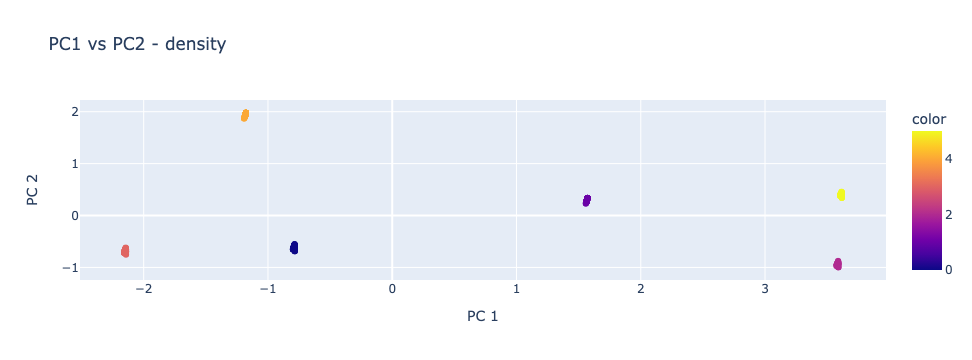

In [224]:
# density
fig = px.scatter(
    components, x=0, y=1, color=db_demographics['y_db'],
#     title=f'Total Explained Variance: {total_var:.2f}%',
    title=f'PC1 vs PC2 - density',
    labels={'0': 'PC 1', '1': 'PC 2'}
)

fig.show()

In [229]:
resize_demo

,income,age,nbr_children,gender_F,marital_status_A,marital_status_B,y_km,y_db
0,0.181399,0.434211,0.2,0,0,1,2,0
1,0.045818,0.763158,0.0,0,0,1,2,0
2,0.128665,0.328947,0.0,1,1,0,3,1
3,0.330667,0.539474,0.0,1,1,0,3,1
4,0.309066,0.605263,0.4,1,0,0,5,2
...,...,...,...,...,...,...,...,...
742,0.102631,0.302632,0.2,1,0,0,5,2
743,0.183043,0.565789,0.2,0,0,1,2,0
744,0.425231,0.486842,0.4,0,0,1,2,0
745,0.104747,0.315789,0.0,1,0,1,1,3


In [366]:
# LOADING PLOT
# loadings
X = resize_demo
features = X.columns
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

df_loading = pd.DataFrame(loadings, columns=('PC1','PC2'), index = X.columns)


In [367]:
# df_loading.abs().sort_values(by = 'PC1', ascending = False)

,PC1,PC2
marital_status_B,0.459380,0.016468
marital_status_A,0.449601,0.029400
age,0.135077,0.010416
nbr_children,0.093181,0.006504
gender_F,0.044272,0.494735
income,0.043725,0.020427


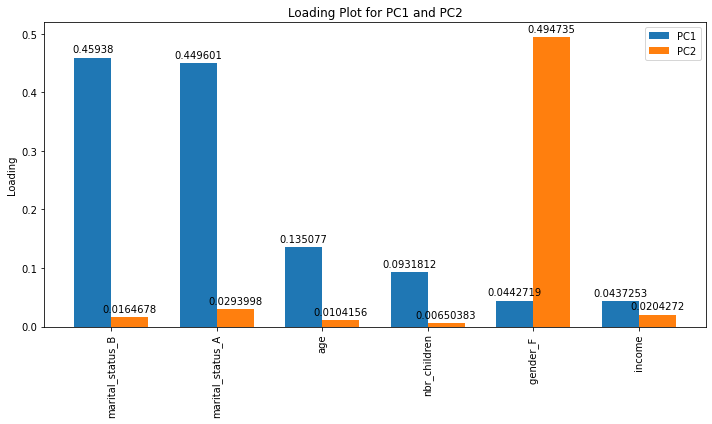

In [368]:
# plot PC1
df_loading_abs = df_loading.abs().sort_values(by = 'PC1', ascending = False).head(10)

df_loading_T = df_loading_abs.T

labels = df_loading_T.columns
PC1 = df_loading_T.loc['PC1']
PC2 = df_loading_T.loc['PC2']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10, 6))
rects1 = ax.bar(x - width/2, PC1, width, label='PC1')
rects2 = ax.bar(x + width/2, PC2, width, label='PC2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loading')
ax.set_title('Loading Plot for PC1 and PC2')
ax.set_xticks(x)
plt.xticks(rotation=90)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

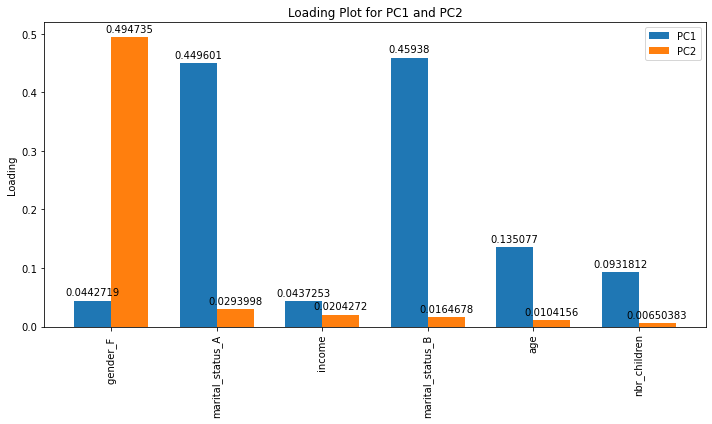

In [369]:
# plot PC2
df_loading_abs = df_loading.abs().sort_values(by = 'PC2', ascending = False).head(10)
df_loading_T = df_loading_abs.T

labels = df_loading_T.columns
PC1 = df_loading_T.loc['PC1']
PC2 = df_loading_T.loc['PC2']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10, 6))
rects1 = ax.bar(x - width/2, PC1, width, label='PC1')
rects2 = ax.bar(x + width/2, PC2, width, label='PC2')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loading')
ax.set_title('Loading Plot for PC1 and PC2')
ax.set_xticks(x)
plt.xticks(rotation=90)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [63]:
# Try it all agin but with only age, marital status, nbr_children and income

### RADAR PLOT

https://plotly.com/python/radar-chart/

** Need to bring back customer id? to relate to banking behaviour???

In [231]:

def plot_radar_chart(df):
    data = []
    for i in range(0,len(df)):
        data.append(go.Scatterpolar(r = df.iloc[i].values,
                                    theta = df.iloc[i].index,
                                    name = f'cluster_{df.index[i]}',
                                    fill = 'toself'))
    # mean line
    data.append(go.Scatterpolar(r = [100]* df.shape[1],
                                theta= df.columns,
                                name = 'mean',
                                fill = 'toself'))
    layout = go.Layout(polar = dict(radialaxis = dict(visible = True)),
                       showlegend = True)
    fig = go.Figure(data = data, layout = layout)
    fig.show()

# BANKING BEHAVIOUR

In [ ]:
accounts = pd.read_csv("data/twm_accounts.csv", sep=';')
checking_acct = pd.read_csv("data/twm_checking_acct.csv", sep=';')
checking_tran = pd.read_csv("data/twm_checking_tran.csv", sep=';')
credit_acct = pd.read_csv("data/twm_credit_acct.csv", sep=';')
# customer = pd.read_csv("data/twm_customer.csv", sep=';')
savings_acct = pd.read_csv("data/twm_savings_acct.csv", sep=';')
savings_tran = pd.read_csv("data/twm_savings_tran.csv", sep=';')
transactions = pd.read_csv("data/twm_transactions.csv", sep=';')

In [62]:
accounts.head()
# pk - acct_nbr, cust_id
# maybe add all acounts together on customer_id...
# and all transactions together to describe type and frequency of transactions



,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28


In [253]:
accounts_check = pd.merge(accounts, checking_acct, how = 'inner', on=['cust_id', 'acct_nbr'])
accounts_credit = pd.merge(accounts, credit_acct, how = 'inner', on=['cust_id', 'acct_nbr'])
account_savings =  pd.merge(accounts, credit_acct, how = 'inner', on=['cust_id', 'acct_nbr'])

In [340]:
transactions.head()


,tran_id,acct_nbr,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,27,13625623,0.00,0.00,0.0,3753.34,21.10.1995,121656,A,IQ
1,97,13628392,0.00,0.00,0.0,254.49,5.2.1995,153053,V,IQ
2,21,13630842,-97.57,-97.57,0.0,3819.56,23.7.1995,0,P,WD
3,44,13631412,-0.15,-0.15,0.0,224.05,30.1.1995,0,,FK
4,31,13625722,0.00,0.00,0.0,240.55,25.1.1995,204521,B,IQ


In [328]:

#

In [251]:
# date_split = date.split(sep='.')
# date_split[1]

'7'

In [256]:
# checking_tran['month'] = checking_tran['tran_date']
# checking_tran['month'] = checking_tran['month'].apply(lambda x: x.split(sep='.')[1])
# checking_tran.head()

,cust_id,tran_id,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code,month
0,1363481,26,-0.15,-0.15,0.0,58.99,29.1.1995,,,FK,1
1,1362784,90,-200.00,-200.00,0.0,1380.69,2.7.1995,53313,A,WD,7
2,1363088,46,0.00,0.00,0.0,128.35,26.3.1995,834,A,IQ,3
3,1363306,32,-40.32,-40.32,0.0,433.06,29.1.1995,,P,WD,1
4,1363251,11,-87.88,-87.88,0.0,1919.55,8.2.1995,,P,WD,2


In [258]:
# checking_tran['year'] = checking_tran['tran_date']
# checking_tran['year'] = checking_tran['year'].apply(lambda x: x.split(sep='.')[2])

transations

In [292]:
# Total number of tranactions

df = checking_tran[['tran_amt', 'cust_id']].groupby(by=['cust_id'], as_index=False ).count()
df.rename(columns={"tran_amt": "trans_count"})


,cust_id,trans_count
0,1362480,99
1,1362484,99
2,1362485,99
3,1362486,25
4,1362487,52
...,...,...
515,1363483,99
516,1363484,99
517,1363492,99
518,1363493,99


In [293]:
# my_filter = checking_tran[['tran_amt', 'cust_id']].groupby(by=['cust_id'], as_index=False ).mean()
# my_filter

In [294]:
# # Average checking transaction amount


my_filter = checking_tran[['tran_amt', 'cust_id']].groupby(by=['cust_id'], as_index=False ).mean()

df['avg_trans'] = my_filter["tran_amt"]
# df


,cust_id,tran_amt,avg_trans
0,1362480,99,-2.474646
1,1362484,99,-25.435758
2,1362485,99,-1.659495
3,1362486,25,-37.604800
4,1362487,52,-26.513269
...,...,...,...
515,1363483,99,2.617273
516,1363484,99,-23.918283
517,1363492,99,-12.570404
518,1363493,99,-41.110505


In [333]:
credit_acct.isnull().sum().sort_values(ascending=False)

acct_end_date       423
ending_balance        0
starting_balance      0
acct_start_date       0
account_active        0
credit_rating         0
credit_limit          0
acct_nbr              0
cust_id               0
dtype: int64

cust_id               int64
acct_nbr              int64
credit_limit          int64
credit_rating         int64
account_active       object
acct_start_date      object
acct_end_date        object
starting_balance    float64
ending_balance      float64
dtype: object

In [339]:
df['credit_debt'] = 0
df['credit_debt'] = credit_acct['starting_balance']-credit_acct['ending_balance']

In [338]:
df

NameError: name 'missing_percent_drop_threshold' is not defined

In [312]:
accounts_copy = accounts
accounts_copy = accounts_copy.drop_duplicates(subset=['cust_id'])
accounts_copy = pd.merge(accounts_copy, df, how = 'inner', on=['cust_id'])
accounts_copy['has_checking'] =0
accounts_copy

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance,tran_amt,avg_trans,credit_debt,has_checking
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58,99,23.664343,-2000.00,0
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15,99,-20.890303,2026.85,0
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00,99,-2.146465,-1567.71,0
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46,99,-101.501717,-2648.63,0
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28,99,-36.654646,-1200.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
515,13630032,1363003,CK,Y,16.8.1990,NaN,153.23,177.26,99,0.242727,-821.95,0
516,13632352,1363235,CK,Y,29.9.1993,NaN,2887.85,1067.57,99,-18.386667,579.32,0
517,13634152,1363415,CK,Y,29.12.1995,NaN,2717.85,21.41,99,-27.236768,NaN,0
518,13630982,1363098,CK,Y,25.5.1995,NaN,2874.57,17.71,99,-28.857172,-1000.00,0


In [319]:

# accounts_copy['has_checking'] = accounts_copy['has_checking'].apply(lambda x: x.replace{'Y':1,'N':0} )
# l1 = list(filter(lambda x: x["account_active"] == 'CC  ' and x["account_active"] == 'Y', accounts_copy))
# newdf = accounts_copy[accounts_copy.apply(lambda x: x["account_active"] == 'CC  ' and x["account_active"] == 'Y', axis=1)]

In [320]:
newdf

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance,tran_amt,avg_trans,credit_debt,has_checking


In [327]:
my_filter = accounts_copy[(accounts_copy['account_active'] =='Y ') and (accounts_copy['acct_type'] == 'CC  ')].index.tolist()
my_filter



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
transactions.head()

In [ ]:
transaction 